In [36]:
#initiate spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [37]:
#import necessaty libraries
from pyspark.sql.functions import max, min, col, hash, expr
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.sql.types import StringType, NumericType, IntegerType
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns


In [38]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [40]:
#load the data set
df = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("/Users/jildoubrink/Desktop/Big data Analytics/datasets/scrubbed.csv")

df.printSchema()

root
 |-- datetime: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)
 |-- shape: string (nullable = true)
 |-- duration (seconds): string (nullable = true)
 |-- duration (hours/min): string (nullable = true)
 |-- comments: string (nullable = true)
 |-- date posted: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude : double (nullable = true)



In [41]:
#create temporary view to enable SQL queries
df.createOrReplaceTempView("dfTable")

## 1. explore the data

In [42]:
df.show(20)

+----------------+--------------------+-----+-------+--------+------------------+--------------------+--------------------+-----------+----------+------------+
|        datetime|                city|state|country|   shape|duration (seconds)|duration (hours/min)|            comments|date posted|  latitude|  longitude |
+----------------+--------------------+-----+-------+--------+------------------+--------------------+--------------------+-----------+----------+------------+
|10/10/1949 20:30|          san marcos|   tx|     us|cylinder|              2700|          45 minutes|This event took p...|  4/27/2004|29.8830556| -97.9411111|
|10/10/1949 21:00|        lackland afb|   tx|   NULL|   light|              7200|             1-2 hrs|1949 Lackland AFB...| 12/16/2005|  29.38421|  -98.581082|
|10/10/1955 17:00|chester (uk/england)| NULL|     gb|  circle|                20|          20 seconds|Green/Orange circ...|  1/21/2008|      53.2|   -2.916667|
|10/10/1956 21:00|                edna| 

#### fill in missing values

In [43]:
#fill in the null values
df = df.na.fill("NA")
df.show(20)

+----------------+--------------------+-----+-------+--------+------------------+--------------------+--------------------+-----------+----------+------------+
|        datetime|                city|state|country|   shape|duration (seconds)|duration (hours/min)|            comments|date posted|  latitude|  longitude |
+----------------+--------------------+-----+-------+--------+------------------+--------------------+--------------------+-----------+----------+------------+
|10/10/1949 20:30|          san marcos|   tx|     us|cylinder|              2700|          45 minutes|This event took p...|  4/27/2004|29.8830556| -97.9411111|
|10/10/1949 21:00|        lackland afb|   tx|     NA|   light|              7200|             1-2 hrs|1949 Lackland AFB...| 12/16/2005|  29.38421|  -98.581082|
|10/10/1955 17:00|chester (uk/england)|   NA|     gb|  circle|                20|          20 seconds|Green/Orange circ...|  1/21/2008|      53.2|   -2.916667|
|10/10/1956 21:00|                edna| 

#### find the total number of sightings

In [44]:
df.count()

80332

#### find the date with the most sightings

In [45]:
#group by date and count the number of sightings for each date
sightings_by_date = df.groupBy("datetime").count()

#find the date with the maximum number of sightings
max_sightings_date = sightings_by_date.orderBy(col("count").desc()).first()["datetime"]
max_sightings_count = sightings_by_date.orderBy(col("count").desc()).first()["count"]

print("Date with the most sightings:", max_sightings_date)
print("Number of sightings on that date:", max_sightings_count)


Date with the most sightings: 7/4/2010 22:00
Number of sightings on that date: 36


#### find the duration of the longest sighting

In [46]:
#change string to float for good access to data for calculations
df = df.withColumn("duration (seconds)", df["duration (seconds)"].cast("float"))

#find the row(s) with the longest duration
longest_sightings = df.orderBy(col("duration (seconds)").desc()).limit(1)

#display the details of the longest sighting(s)
longest_sightings.show()


+---------------+--------------------+-----+-------+------+------------------+--------------------+--------------------+-----------+---------+----------+
|       datetime|                city|state|country| shape|duration (seconds)|duration (hours/min)|            comments|date posted| latitude|longitude |
+---------------+--------------------+-----+-------+------+------------------+--------------------+--------------------+-----------+---------+----------+
|10/1/1983 17:00|birmingham (uk/en...|   NA|     gb|sphere|          9.7836E7|            31 years|Firstly&#44 I was...|  4/12/2013|52.466667| -1.916667|
+---------------+--------------------+-----+-------+------+------------------+--------------------+--------------------+-----------+---------+----------+



#### find the shortest duration of the sighting

In [47]:
#find the record with the longest duration
longest_sightings = df.orderBy(col("duration (seconds)").asc()).limit(1)

#display the details of the longest sighting(s)
longest_sightings.show()

+--------------+-----+-----+-------+-----+------------------+--------------------+--------------------+-----------+----------+----------+
|      datetime| city|state|country|shape|duration (seconds)|duration (hours/min)|            comments|date posted|  latitude|longitude |
+--------------+-----+-----+-------+-----+------------------+--------------------+--------------------+-----------+----------+----------+
|2/2/2000 19:33|bouse|   az|     us|   NA|              NULL|  each a few seconds|Driving through P...|  2/16/2000|33.9325000|  -114.005|
+--------------+-----+-----+-------+-----+------------------+--------------------+--------------------+-----------+----------+----------+



#### find the country with the most sightings


In [48]:
#group by country and count the number of sightings for each country
sightings_by_country = df.groupBy("country").count()

#find the country with the most sightings
max_sightings_country = sightings_by_country.orderBy(col("count").desc()).select("country").first()["country"]
max_sightings_count = sightings_by_country.orderBy(col("count").desc()).first()["count"]

print("Country with the most sightings:", max_sightings_country)
print("Number of sightings in that country:", max_sightings_count)


Country with the most sightings: us
Number of sightings in that country: 65114


#### find the sighting with the highest longitude

In [49]:
#convert the longitude column from string to float
df = df.withColumn("longitude", df["longitude "].cast("float"))

#find the maximum longitude value
max_longitude = df.agg(max(col("longitude "))).first()[0]

#filter the DataFrame to retrieve the sighting with the highest longitude
highest_longitude_sighting = df.filter(df["longitude "] == max_longitude).first()


#display specific details of the sighting with the highest longitude
print("Date:", highest_longitude_sighting["datetime"])
print("Longitude:", highest_longitude_sighting["longitude "])


Date: 11/23/2008 20:30
Longitude: 178.4419


DataFrame[datetime: string, city: string, state: string, country: string, shape: string, duration (seconds): float, duration (hours/min): string, comments: string, date posted: string, latitude: string, longitude : double, longitude: float]

In [50]:
df.printSchema()

root
 |-- datetime: string (nullable = false)
 |-- city: string (nullable = false)
 |-- state: string (nullable = false)
 |-- country: string (nullable = false)
 |-- shape: string (nullable = false)
 |-- duration (seconds): float (nullable = true)
 |-- duration (hours/min): string (nullable = false)
 |-- comments: string (nullable = false)
 |-- date posted: string (nullable = false)
 |-- latitude: string (nullable = false)
 |-- longitude : double (nullable = true)
 |-- longitude: float (nullable = true)



In [51]:
df = df.drop("longitude ")
#there was this extra space after the column longitude so i created a new one and dropped the old one

In [52]:
df.printSchema()
#checked if i dropped it 

root
 |-- datetime: string (nullable = false)
 |-- city: string (nullable = false)
 |-- state: string (nullable = false)
 |-- country: string (nullable = false)
 |-- shape: string (nullable = false)
 |-- duration (seconds): float (nullable = true)
 |-- duration (hours/min): string (nullable = false)
 |-- comments: string (nullable = false)
 |-- date posted: string (nullable = false)
 |-- latitude: string (nullable = false)
 |-- longitude: float (nullable = true)



#### find the sighting with the lowest latitude

In [53]:
#convert the latitude column from string to float
df = df.withColumn("latitude", df["latitude"].cast("float"))

#find the minimum latitude value
min_latitude = df.agg(min(col("latitude"))).first()[0]

#filter the DataFrame to retrieve the sighting with the lowest latitude
lowest_latitude_sighting = df.filter(df["latitude"] == min_latitude).first()

#display specific details of the sighting with the highest longitude
print("Date:", lowest_latitude_sighting["datetime"])
print("Latitude:", lowest_latitude_sighting["latitude"])


Date: 5/15/1994 13:00
Latitude: -82.86275482177734


#### find the most and least common shapes of a sighting

In [54]:
#group by the "shape" column and count the occurrences of each shape
shape_counts = df.groupBy("shape").count()

#find the most common shape
most_common_shape = shape_counts.orderBy(col("count").desc()).first()

#find the least common shape
least_common_shape = shape_counts.orderBy(col("count")).first()

#display the most and least common shapes
print("Most common shape:", most_common_shape["shape"], "with count:", most_common_shape["count"])
print("Least common shape:", least_common_shape["shape"], "with count:", least_common_shape["count"])


Most common shape: light with count: 16565
Least common shape: hexagon with count: 1


#### some visualisations

+-------+-----+
|country|count|
+-------+-----+
|     us|65114|
|     NA| 9670|
|     au|  538|
|     gb| 1905|
|     de|  105|
|     ca| 3000|
+-------+-----+



/var/folders/fw/7k53rvcn4rnc2xcnsxljfw7m0000gn/T/ipykernel_83112/2725384687.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='country', data=country_sightings_pd, palette='viridis')


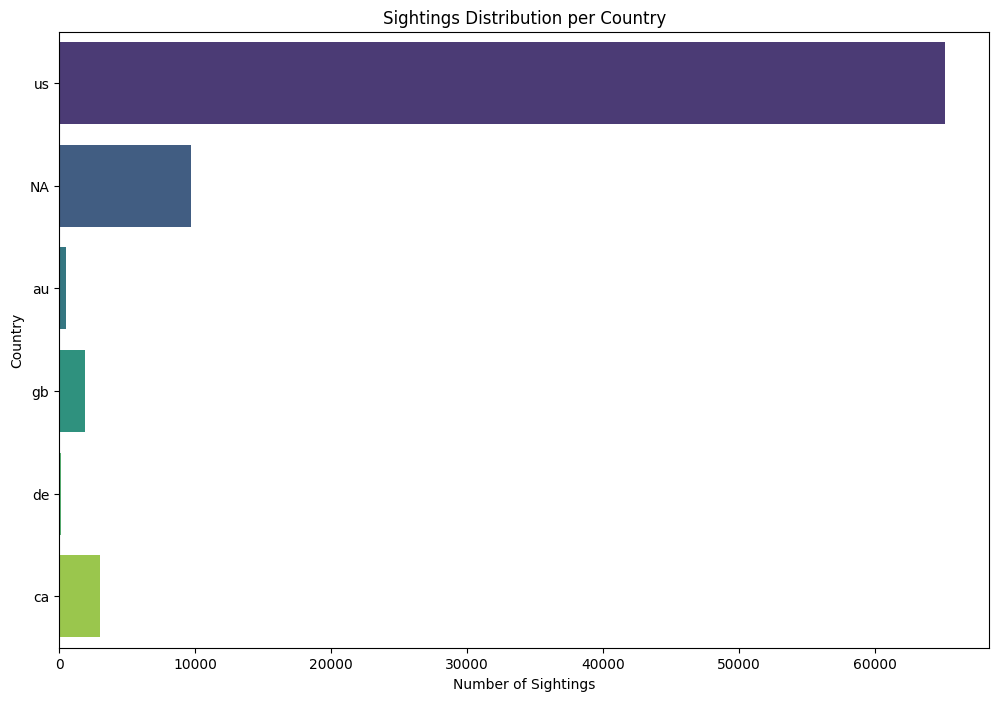

In [55]:
#group by country and count sightings
country_sightings = df.groupBy("country").count()

#show the result
country_sightings.show()

#convert to Pandas DataFrame
country_sightings_pd = country_sightings.toPandas()

#plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='country', data=country_sightings_pd, palette='viridis')
plt.title('Sightings Distribution per Country')
plt.xlabel('Number of Sightings')
plt.ylabel('Country')
plt.show()



+---------+-----+
|    shape|count|
+---------+-----+
|   circle| 7608|
| fireball| 6208|
| cylinder| 1283|
|    delta|    7|
|    cigar| 2057|
|       NA| 1932|
|  unknown| 5584|
|  hexagon|    1|
|    flare|    1|
|    light|16565|
|     cone|  316|
|formation| 2457|
|    other| 5649|
|    round|    2|
| triangle| 7865|
|  diamond| 1178|
|rectangle| 1297|
| teardrop|  750|
|      egg|  759|
| changing| 1962|
+---------+-----+
only showing top 20 rows



/var/folders/fw/7k53rvcn4rnc2xcnsxljfw7m0000gn/T/ipykernel_83112/1150866902.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='shape', data=shape_sightings_pd, palette='viridis')


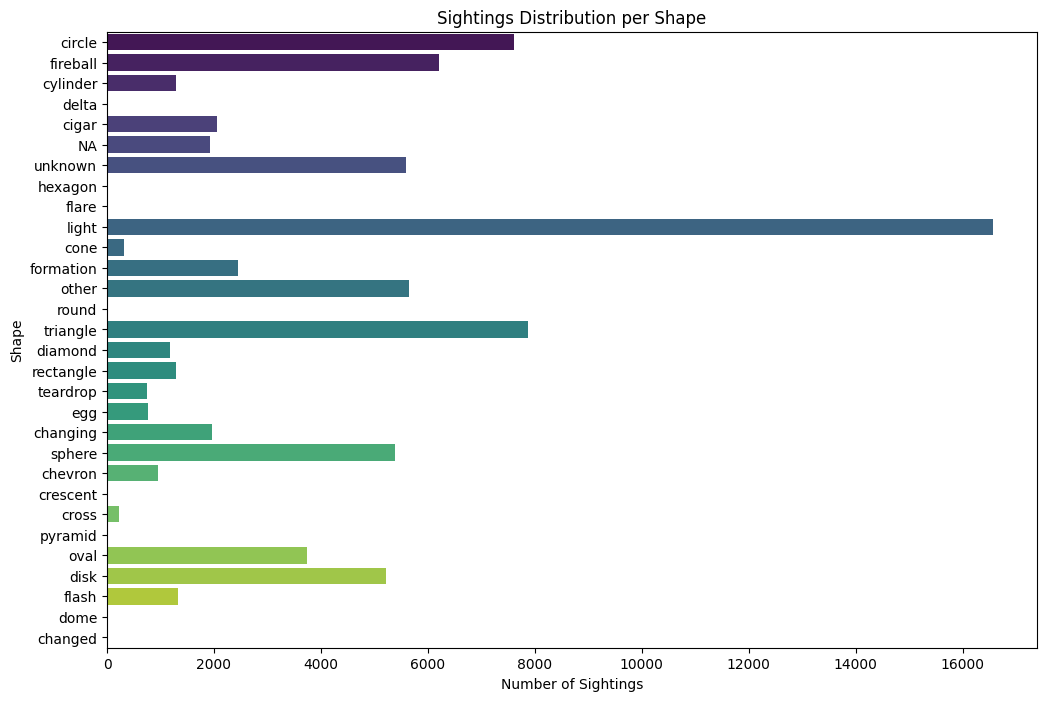

In [56]:
#group by shape and count sightings
shape_sightings = df.groupBy("shape").count()

#show the result
shape_sightings.show()

#convert to Pandas DataFrame
shape_sightings_pd = shape_sightings.toPandas()

#plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='shape', data=shape_sightings_pd, palette='viridis')
plt.title('Sightings Distribution per Shape')
plt.xlabel('Number of Sightings')
plt.ylabel('Shape')
plt.show()

## 2. univariate and bivariate descriptors

#### univariate 

In [57]:
# Mean
mean_duration = df.agg({'duration (seconds)': 'mean'}).collect()[0][0]
mean_longitude = df.agg({'longitude': 'mean'}).collect()[0][0]

# Median
median_duration = df.approxQuantile("duration (seconds)", [0.5], 0.01)[0]
median_longitude = df.approxQuantile("longitude", [0.5], 0.01)[0]

# Mode
mode_duration = df.groupBy("duration (seconds)").count().orderBy("count", ascending=False).first()[0]
mode_longitude = df.groupBy("longitude").count().orderBy("count", ascending=False).first()[0]

print(f"Mean duration: {mean_duration}, Median duration: {median_duration}, Mode duration: {mode_duration}")
print(f"Mean longitude: {mean_longitude}, Median longitude: {median_longitude}, Mode longitude: {mode_longitude}")


Mean duration: 9017.225634092258, Median duration: 180.0, Mode duration: 300.0
Mean longitude: -86.77288441755051, Median longitude: -88.00749969482422, Mode longitude: -122.3308334350586


In [58]:
# Standard Deviation and Variance
stddev_duration = df.agg({'duration (seconds)': 'stddev'}).collect()[0][0]
variance_duration = df.agg({'duration (seconds)': 'variance'}).collect()[0][0]

stddev_longitude = df.agg({'longitude': 'stddev'}).collect()[0][0]
variance_longitude = df.agg({'longitude': 'variance'}).collect()[0][0]

print(f"Stddev duration: {stddev_duration}, Variance duration: {variance_duration}")
print(f"Stddev longitude: {stddev_longitude}, Variance longitude: {variance_longitude}")


Stddev duration: 620228.3693176169, Variance duration: 384683230106.3902
Stddev longitude: 39.69720465603189, Variance longitude: 1575.86805750288


#### bivariate

                    duration (seconds)  latitude  longitude
duration (seconds)            1.000000  0.002646   0.006452
latitude                      0.002646  1.000000  -0.390165
longitude                     0.006452 -0.390165   1.000000


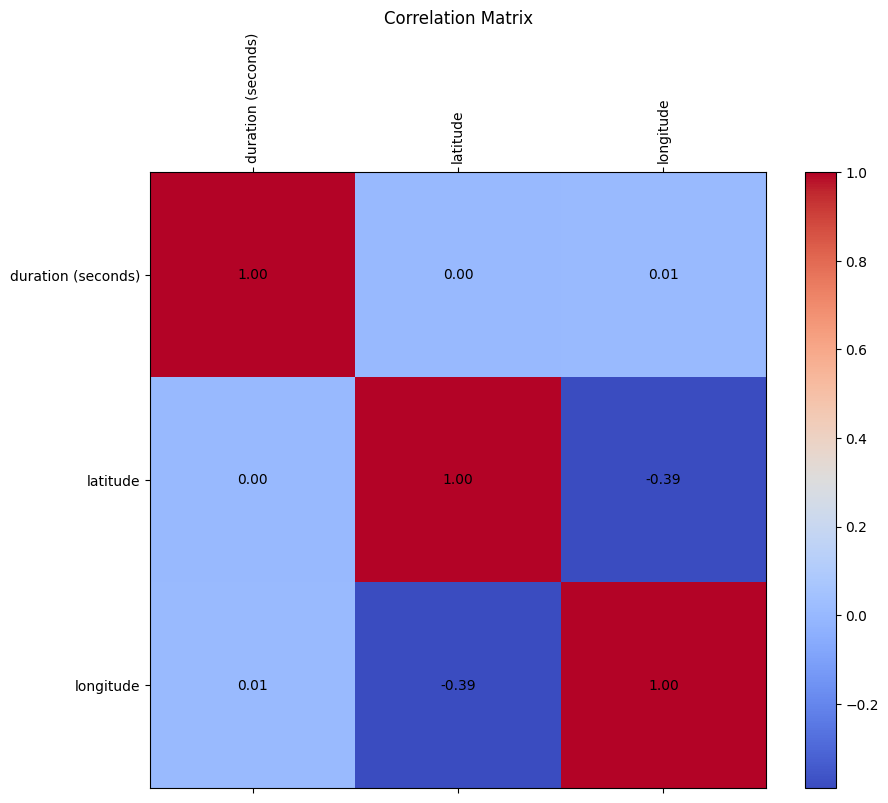

In [59]:
#select numeric columns
numeric_columns = [field.name for field in df.schema.fields if field.dataType.simpleString() in ["int", "double", "float"]]

#initialize an empty dictionary to store correlation values
correlations = {}

#compute correlation coefficients for each pair of numeric columns
for col1 in numeric_columns:
    for col2 in numeric_columns:
        if col1 != col2:
            corr_value = df.stat.corr(col1, col2)
            correlations[(col1, col2)] = corr_value

#create a correlation matrix
matrix = np.zeros((len(numeric_columns), len(numeric_columns)))

for i, col1 in enumerate(numeric_columns):
    for j, col2 in enumerate(numeric_columns):
        if i == j:
            matrix[i, j] = 1.0  # Diagonal elements are 1
        else:
            matrix[i, j] = correlations.get((col1, col2), correlations.get((col2, col1), 0.0))

#convert the matrix to a Pandas DataFrame for better visualization
correlation_matrix = pd.DataFrame(matrix, index=numeric_columns, columns=numeric_columns)
print(correlation_matrix)

#visualize the correlation matrix using Matplotlib
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(correlation_matrix, cmap='coolwarm')

#add color bar
fig.colorbar(cax)

#set axis labels
ax.set_xticks(np.arange(len(numeric_columns)))
ax.set_yticks(np.arange(len(numeric_columns)))
ax.set_xticklabels(numeric_columns, rotation=90)
ax.set_yticklabels(numeric_columns)

#annotate each cell with the numeric value
for i in range(len(numeric_columns)):
    for j in range(len(numeric_columns)):
        plt.text(i, j, f"{matrix[i, j]:.2f}", ha='center', va='center', color='black')

plt.title("Correlation Matrix")
plt.show()


##### results
results show that the variables are not really correlated. Only latitude and longitude have a moderate nnegative correlation of 0.39. This means that there is an inverse relationship between latitude and longitude. When one increases, the other tends to decrease 

In [60]:
#drop rows with null values in the feature or label columns
df = df.dropna(subset=['latitude', 'longitude', 'duration (seconds)']) 


In [61]:
#convert to Pandas DataFrame
pandas_df = df.toPandas()


In [62]:
X = pandas_df[['longitude', 'latitude']]  #independent variables
y = pandas_df['duration (seconds)']    #dependent variable

#add a constant to the independent variables
X = sm.add_constant(X)

#fit the regression model
model = sm.OLS(y, X).fit()

#print the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     duration (seconds)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.937
Date:                Sun, 02 Jun 2024   Prob (F-statistic):             0.0530
Time:                        20:59:32   Log-Likelihood:            -1.1854e+06
No. Observations:               80328   AIC:                         2.371e+06
Df Residuals:                   80325   BIC:                         2.371e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7230.3825   8461.631      0.854      0.3

##### results
results show this model is not a good fit. Both the r-squared and the adjusted r-squared are 0.
the f-statistic is also quite low (2.937) indicating that the independent variables do not have a significant effect on the dependent variable. In this case, the longitude and latitude of a sighting are not related to the duration of a sighting

## 3. binary classification

#### logistic regression

In [63]:
#clean column names
for col_name in df.columns:
    df = df.withColumnRenamed(col_name, col_name.strip())

In [64]:
#identify categorical columns
categorical_cols = [col for col in df.columns if isinstance(df.schema[col].dataType, StringType) and col != 'shape']
print("Categorical columns:", categorical_cols)

#index categorical columns
for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+"_index")
    df = indexer.fit(df).transform(df)
    print(f"Indexed {col} column")

#index the target variable
label_indexer = StringIndexer(inputCol="shape", outputCol="shape_index")
df = label_indexer.fit(df).transform(df)

#verify all columns are indexed
df.printSchema()

Categorical columns: ['datetime', 'city', 'state', 'country', 'duration (hours/min)', 'comments', 'date posted']
Indexed datetime column
Indexed city column
Indexed state column
Indexed country column
Indexed duration (hours/min) column
Indexed comments column
Indexed date posted column
root
 |-- datetime: string (nullable = false)
 |-- city: string (nullable = false)
 |-- state: string (nullable = false)
 |-- country: string (nullable = false)
 |-- shape: string (nullable = false)
 |-- duration (seconds): float (nullable = true)
 |-- duration (hours/min): string (nullable = false)
 |-- comments: string (nullable = false)
 |-- date posted: string (nullable = false)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- datetime_index: double (nullable = false)
 |-- city_index: double (nullable = false)
 |-- state_index: double (nullable = false)
 |-- country_index: double (nullable = false)
 |-- duration (hours/min)_index: double (nullable = false)
 |-- com

In [65]:
#identify numeric columns
numeric_cols = [col for col in df.columns if isinstance(df.schema[col].dataType, NumericType)]

#assemble features without the shape and index colum
assembler = VectorAssembler(
    inputCols=[col+"_index" if col in categorical_cols else col for col in df.columns if col not in ["shape", "shape_index"]], 
    outputCol="features")

#transform the dataframe to include the features column
df = assembler.transform(df)

#verify the new DataFrame schema
df.printSchema()


root
 |-- datetime: string (nullable = false)
 |-- city: string (nullable = false)
 |-- state: string (nullable = false)
 |-- country: string (nullable = false)
 |-- shape: string (nullable = false)
 |-- duration (seconds): float (nullable = true)
 |-- duration (hours/min): string (nullable = false)
 |-- comments: string (nullable = false)
 |-- date posted: string (nullable = false)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- datetime_index: double (nullable = false)
 |-- city_index: double (nullable = false)
 |-- state_index: double (nullable = false)
 |-- country_index: double (nullable = false)
 |-- duration (hours/min)_index: double (nullable = false)
 |-- comments_index: double (nullable = false)
 |-- date posted_index: double (nullable = false)
 |-- shape_index: double (nullable = false)
 |-- features: vector (nullable = true)



In [66]:
#create unique identifiers for each row based on the feature vector
df = df.withColumn("unique_id", hash("features"))

#split into training and temporary sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


In [67]:
df.printSchema()

root
 |-- datetime: string (nullable = false)
 |-- city: string (nullable = false)
 |-- state: string (nullable = false)
 |-- country: string (nullable = false)
 |-- shape: string (nullable = false)
 |-- duration (seconds): float (nullable = true)
 |-- duration (hours/min): string (nullable = false)
 |-- comments: string (nullable = false)
 |-- date posted: string (nullable = false)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- datetime_index: double (nullable = false)
 |-- city_index: double (nullable = false)
 |-- state_index: double (nullable = false)
 |-- country_index: double (nullable = false)
 |-- duration (hours/min)_index: double (nullable = false)
 |-- comments_index: double (nullable = false)
 |-- date posted_index: double (nullable = false)
 |-- shape_index: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- unique_id: integer (nullable = false)



In [68]:
#select only the required columns for model training
final_train_df = train_df.select("features", "shape_index")
final_test_df = test_df.select("features", "shape_index")

#initialise logistic regression
lr = LogisticRegression(labelCol="shape_index", featuresCol="features")

#train the model
model = lr.fit(final_train_df)

#make predictions
predictions = model.transform(final_test_df)


24/06/02 20:59:35 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
24/06/02 20:59:36 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
24/06/02 20:59:36 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
24/06/02 20:59:36 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
24/06/02 20:59:36 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
24/06/02 20:59:37 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
24/06/02 20:59:37 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
24/06/02 20:59:37 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
24/06/02 20:59:37 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
24/06/02 20:59:37 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
24/06/02 20:59:38 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
24/06/02 20:59:38 WARN DAGScheduler: Broadc

In [69]:
# Evaluate the model
#calculate accuracy
correct_predictions = predictions.filter(expr("prediction = shape_index")).count()
total_predictions = predictions.count()
accuracy = correct_predictions / total_predictions

#additional metrics: precision, recall, F1-score
evaluator_precision = MulticlassClassificationEvaluator(labelCol="shape_index", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)

evaluator_recall = MulticlassClassificationEvaluator(labelCol="shape_index", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="shape_index", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)

#print results
print(f"Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

24/06/02 20:59:57 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
24/06/02 20:59:57 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
24/06/02 20:59:58 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
24/06/02 20:59:59 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
24/06/02 20:59:59 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


Model Accuracy: 0.20715951345559966
Precision: 0.042917768859735035
Recall: 0.20715951345559966
F1 Score: 0.0711046124083492


##### results
model accuracy: Model accuracy measures the overall correctness of the predictions made by the model. An accuracy of 0.207 means that the model correctly predicted 20.7% of the instances in the dataset.

precision: Precision measures the proportion of true positive predictions among all positive predictions made by the model. A precision of 0.043 means that among all instances predicted as positive by the model, only 4.3% were actually true positives.

recall: Recall measures the proportion of true positives that were correctly identified by the model among all actual positive instances. A recall of 0.207 indicates that the model correctly identified 20.7% of all actual positive instances.

f1: the F1 score is the harmonic mean of precision and recall. It provides a balance between precision and recall. A higher F1 score indicates better performance, balancing both precision and recall. An F1 score of 0.071 suggests that the model achieves low performance in terms of both precision and recall.

#### decision trees


In [70]:
from pyspark.sql.functions import col as sql_col

#select necessary columns and drop rows with missing values in those columns
df = df.select("shape", "country").dropna()

#filter out infrequent categories in 'shape' to reduce the number of unique values
#i had to do this since i kept getting an error about unique values being too big
shape_counts = df.groupBy("shape").count()
filtered_shapes = shape_counts.filter(sql_col("count") > 100).select("shape").rdd.flatMap(lambda x: x).collect()
df = df.filter(sql_col("shape").isin(filtered_shapes))

#index categorical feature "shape"
indexer = StringIndexer(inputCol="shape", outputCol="shape_index")
df = indexer.fit(df).transform(df)

#one-hot encode the indexed feature
encoder = OneHotEncoder(inputCols=["shape_index"], outputCols=["shape_encoded"])
df = encoder.fit(df).transform(df)

#assemble feature vector
assembler = VectorAssembler(inputCols=["shape_encoded"], outputCol="features")
df = assembler.transform(df)

#split data into training and test sets
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

#initialize decision tree classifier
dt = DecisionTreeClassifier(labelCol="shape_index", featuresCol="features", maxBins=100)

#train the model
dt_model = dt.fit(train_df)

#make predictions
predictions = dt_model.transform(test_df)






Model Accuracy: 0.6180133338924064


In [72]:
#evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="shape_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

#initialize the MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="shape_index", predictionCol="prediction")

#calculate precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})

#calculate recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

#calculate F1 score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

#print the results
print(f"Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


Model Accuracy: 0.899618432638685
Precision: 0.8320576071870927
Recall: 0.8996184326386851
F1 Score: 0.859236362111619


##### results
Model Accuracy: The proportion of correct predictions out of the total number of predictions. In this case, around 89.96% of the predictions made by the model were correct.

Precision: The ratio of true positive predictions to the total number of positive predictions made by the model. In this case, around 83.21% of the predicted positive sightings were actually positive.

Recall: The ratio of true positive predictions to the total number of actual positive instances in the data. In this case, around 89.96% of the actual positive sightings were correctly identified by the model.

F1 Score: The harmonic mean of precision and recall, providing a balance between the two metrics. It is useful when the classes are imbalanced. In this case, it's around 85.92%.



#### random forest

In [76]:
#initialize random forest classifier
rf = RandomForestClassifier(labelCol="shape_index", featuresCol="features", numTrees=100, maxBins=100)

#train the model
rf_model = rf.fit(train_df)

#make predictions
predictions = rf_model.transform(test_df)

#initialize the MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="shape_index", predictionCol="prediction")

#evaluate the accuracy of the Random Forest model
accuracy = evaluator.evaluate(predictions)

#calculate precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})

#calculate recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

#calculate F1 score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

#print the results
print(f"Random Forest Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


Random Forest Model Accuracy: 0.859236362111619
Precision: 0.8320576071870927
Recall: 0.8996184326386851
F1 Score: 0.859236362111619


##### results
Model Accuracy: The proportion of correct predictions out of the total number of predictions. It's reported as 85.92%, which means around 85.92% of the model's predictions were correct.

Precision: The ratio of true positive predictions to the total number of positive predictions made by the model. It's reported as approximately 83.21%, indicating that out of all the instances the model classified as positive, around 83.21% were actually positive.

Recall: The ratio of true positive predictions to the total number of actual positive instances in the data. It's reported as around 89.96%, meaning that out of all the actual positive instances, around 89.96% were correctly identified by the model.

F1 Score: The harmonic mean of precision and recall, providing a balance between the two metrics. It's reported as 85.92%. This value should typically not match the accuracy unless the dataset is perfectly balanced.

## conclusion
The Random Forest model consistently shows higher values for accuracy, precision, recall, and F1 Score compared to the Decision Tree model. Therefore, based on these metrics, the Random Forest model is the better-performing model.